In [41]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms
from PIL import Image

# ---------- PARAMETERS ----------
VIDEO_PATH = "/home/vedbhai/Downloads/Iodine Clock.mp4"
FRAMES_DIR = "frames"
EMBEDDING_PICKLE = "frame_data_with_embeddings.pkl"
REGRESSOR_WEIGHTS = "regressor.pth"
BATCH_SIZE = 32
LR = 1e-3
NUM_EPOCHS = 20

# === CONFIG ===
video_path = "/home/vedbhai/Downloads/Iodine Clock.mp4"
fps_extract_interval = 0.5  # already saved every 0.5s
slowdown_factor = 3
OUTPUT_DIR = "frames"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Load video ===
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
Duration = total_frames / fps

# === Generate set of timestamps that were already saved ===
already_extracted_times = set()
t = 0.0
while t <= Duration:
    already_extracted_times.add(round(t, 2))
    t += fps_extract_interval

frame_idx = 0
saved_idx = 0
metadata_2 = []

# === Loop through frames ===
while True:
    ret, frame = cap.read()
    if not ret:
        break

    video_time = frame_idx / fps
    rounded_time = round(video_time, 2)

    if frame is not None and rounded_time not in already_extracted_times:
        real_time = video_time / slowdown_factor
        filename = f"frame_{saved_idx:03d}_t{real_time:.2f}s.jpg"
        save_path = os.path.join(OUTPUT_DIR, filename)
        cv2.imwrite(save_path, frame)

        metadata_2.append({
            "frame_filename": filename,
            "video_time": video_time,
            "real_time": real_time
        })

        saved_idx += 1

    frame_idx += 1

cap.release()

# Add time_left to metadata
if metadata_2:
    total_real = metadata_2[-1]["real_time"]
    for entry in metadata_2:
        tl = total_real - entry["real_time"]
        entry["time_left"] = max(0.0, tl)
else:
    raise RuntimeError("No frames saved; metadata empty.")

# ---------- STEP 2: COMPUTE CNN EMBEDDINGS ----------
# Load pretrained ResNet18 & strip classification head
resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
resnet = nn.Sequential(*list(resnet.children())[:-1])
resnet.eval()

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Generate embeddings
for entry in metadata_2:
    img_path = os.path.join(FRAMES_DIR, entry["frame_filename"])
    img = Image.open(img_path).convert("RGB")
    tensor = transform(img).unsqueeze(0)
    with torch.no_grad():
        feat = resnet(tensor).view(1, -1).squeeze().numpy()
    entry["cnn_embedding"] = feat

# Build DataFrame and save
df = pd.DataFrame(metadata_2)
df.rename(columns={"frame_filename": "filename"}, inplace=True)
df.to_pickle(EMBEDDING_PICKLE)

# ---------- STEP 3: TRAIN PyTorch REGRESSOR HEAD ----------
# Define model
class TimeRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.head(x)

# Prepare dataset
X = torch.from_numpy(np.stack(df["cnn_embedding"].values)).float()
y = torch.from_numpy(df["time_left"].values).float().unsqueeze(1)
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Instantiate
reg_model = TimeRegressor()
optimizer = optim.Adam(reg_model.parameters(), lr=LR)
criterion = nn.MSELoss()

# Train loop
reg_model.train()
for epoch in range(NUM_EPOCHS):
    total_loss = 0.0
    for bx, by in loader:
        optimizer.zero_grad()
        preds = reg_model(bx)
        loss = criterion(preds, by)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * bx.size(0)
    avg = total_loss / len(loader.dataset)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Loss: {avg:.4f}")

# Save weights
torch.save(reg_model.state_dict(), REGRESSOR_WEIGHTS)

# ---------- STEP 4: INFERENCE FUNCTION ----------
# Reload trained head
reg_model = TimeRegressor()
reg_model.load_state_dict(torch.load(REGRESSOR_WEIGHTS))
reg_model.eval()

# Predict helper
def predict_time_remaining(image_path):
    img = Image.open(image_path).convert("RGB")
    tensor = transform(img).unsqueeze(0)
    with torch.no_grad():
        feat = resnet(tensor).view(1, -1)
        pred = reg_model(feat).item()
    return pred

Epoch 1/20 - Loss: 60.2708
Epoch 2/20 - Loss: 4.2972
Epoch 3/20 - Loss: 1.7766
Epoch 4/20 - Loss: 1.1179
Epoch 5/20 - Loss: 0.7442
Epoch 6/20 - Loss: 0.5541
Epoch 7/20 - Loss: 0.4420
Epoch 8/20 - Loss: 0.3844
Epoch 9/20 - Loss: 0.3531
Epoch 10/20 - Loss: 0.3124
Epoch 11/20 - Loss: 0.2925
Epoch 12/20 - Loss: 0.2626
Epoch 13/20 - Loss: 0.2420
Epoch 14/20 - Loss: 0.2287
Epoch 15/20 - Loss: 0.2169
Epoch 16/20 - Loss: 0.2122
Epoch 17/20 - Loss: 0.1965
Epoch 18/20 - Loss: 0.1884
Epoch 19/20 - Loss: 0.1849
Epoch 20/20 - Loss: 0.1645


In [44]:
import cv2
import os
import pandas as pd
import numpy as np

# ---------- STEP 1: EXTRACT FRAMES & METADATA ----------
FRAMES_DIR = "test_metadata"  # <-- add this line
os.makedirs(FRAMES_DIR, exist_ok=True)
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
interval = int(fps * 0.5)  # every 0.5 sec of video time
slowdown_factor = 3

metadata_1 = []
frame_idx = 0
saved_idx = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    if frame_idx % interval == 0:
        video_time = frame_idx / fps
        real_time = video_time / slowdown_factor
        filename = f"frame_{saved_idx:03d}_t{real_time:.2f}s.jpg"
        path = os.path.join(FRAMES_DIR, filename)
        cv2.imwrite(path, frame)

        metadata_1.append({
            "frame_filename": filename,
            "video_time": video_time,
            "real_time": real_time
        })

        saved_idx += 1
    frame_idx += 1

cap.release()

# === Save metadata as CSV ===
df = pd.DataFrame(metadata_1)
df.to_csv(os.path.join(FRAMES_DIR, "test_metadata.csv"), index=False)  # <-- changed OUTPUT_DIR to FRAMES_DIR

print("✅ Frames extracted and metadata saved at the interval of 0.5 seconds.")



✅ Frames extracted and metadata saved at the interval of 0.5 seconds.


In [48]:
df

,frame_filename,video_time,real_time
0,frame_000_t0.00s.jpg,0.000000,0.000000
1,frame_001_t0.16s.jpg,0.467108,0.155703
2,frame_002_t0.31s.jpg,0.934216,0.311405
3,frame_003_t0.47s.jpg,1.401324,0.467108
4,frame_004_t0.62s.jpg,1.868432,0.622811
...,...,...,...
183,frame_183_t28.49s.jpg,85.480744,28.493581
184,frame_184_t28.65s.jpg,85.947852,28.649284
185,frame_185_t28.80s.jpg,86.414960,28.804987
186,frame_186_t28.96s.jpg,86.882068,28.960689


In [45]:
# Example usage
if __name__ == "__main__":
    test_image = '/home/vedbhai/Downloads/test_metadata/frame_064_t9.96s.jpg'
    print("Predicted time remaining:", predict_time_remaining(test_image), "seconds")

Predicted time remaining: 19.373138427734375 seconds


In [49]:
import os
ans = list()

def process_frame(frame_path):
    print(frame_path)
    ans.append(predict_time_remaining(frame_path))

def process_all_frames(folder_path):
    new = list(np.arange(188))
    for fname in os.listdir('test_metadata'):
            if not fname.lower().endswith(".jpg"):
                continue
            full_path = os.path.join('test_metadata', fname)
            frame_number = int(os.path.splitext(full_path.split('/')[-1])[0].split('_')[1])
            new[frame_number]=full_path

    for fname in new:
        process_frame(fname)

if __name__ == "__main__":
    process_all_frames("test_metadata")

test_metadata/frame_000_t0.00s.jpg
test_metadata/frame_001_t0.16s.jpg
test_metadata/frame_002_t0.31s.jpg
test_metadata/frame_003_t0.47s.jpg
test_metadata/frame_004_t0.62s.jpg
test_metadata/frame_005_t0.78s.jpg
test_metadata/frame_006_t0.93s.jpg
test_metadata/frame_007_t1.09s.jpg
test_metadata/frame_008_t1.25s.jpg
test_metadata/frame_009_t1.40s.jpg
test_metadata/frame_010_t1.56s.jpg
test_metadata/frame_011_t1.71s.jpg
test_metadata/frame_012_t1.87s.jpg
test_metadata/frame_013_t2.02s.jpg
test_metadata/frame_014_t2.18s.jpg
test_metadata/frame_015_t2.34s.jpg
test_metadata/frame_016_t2.49s.jpg
test_metadata/frame_017_t2.65s.jpg
test_metadata/frame_018_t2.80s.jpg
test_metadata/frame_019_t2.96s.jpg
test_metadata/frame_020_t3.11s.jpg
test_metadata/frame_021_t3.27s.jpg
test_metadata/frame_022_t3.43s.jpg
test_metadata/frame_023_t3.58s.jpg
test_metadata/frame_024_t3.74s.jpg
test_metadata/frame_025_t3.89s.jpg
test_metadata/frame_026_t4.05s.jpg
test_metadata/frame_027_t4.20s.jpg
test_metadata/frame_

In [50]:
with open("ans.txt", "w") as f:
    for item in ans:
        f.write(f"{item}\n")


Text(0.5, 1.0, 'Frame by Frame Time remaining')

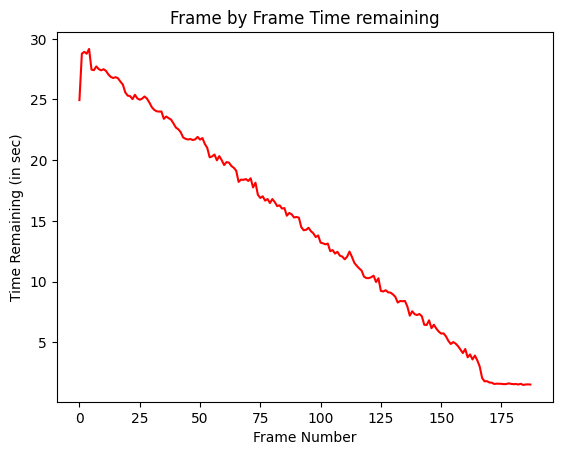

In [51]:
plt.plot(ans,color = 'red')
plt.xlabel('Frame Number')
plt.ylabel('Time Remaining (in sec)')
plt.title('Frame by Frame Time remaining')

(array([28., 17., 18., 20., 16., 16., 19., 19., 18., 17.]),
 array([ 1.47869945,  4.24752433,  7.01634922,  9.78517411, 12.55399899,
        15.32282388, 18.09164877, 20.86047366, 23.62929854, 26.39812343,
        29.16694832]),
 <BarContainer object of 10 artists>)

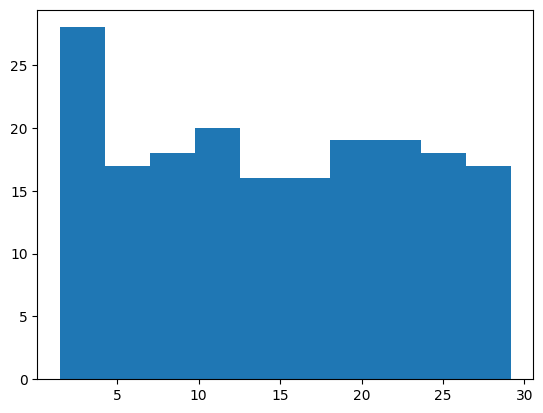

In [53]:
plt.hist(ans)